In [1]:
%%html
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form

In [17]:
import pandas as pd
from IPython.display import HTML
def printmd(string):
    from IPython.display import Markdown, display
    display(Markdown(string))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

### postgresql + python ###
import psycopg2 as pg2

class psql_py:
    def __init__(self):
        self.conn = self.connect_db()
        self.cur = self.conn.cursor()
        self.cur.execute("set search_path = mimiciii;") 
        
    def connect_db(self):
        try:
            conn = pg2.connect("host = localhost dbname=mimic user=postgres port=5432")
            #print('database connected')
            return conn
        except:
            print("I am unable to connect to the database")          
            
    def exe_sql (self, exe_sql_str):
        return pd.read_sql(exe_sql_str,self.conn)
    
    def db_query(self, exe_sql_str, mode='sql'):
        if mode == 'pd':
            return_pd = self.exe_sql (exe_sql_str)
            self.close_db()
            return return_pd
        else: 
            self.cur.execute(exe_sql_str)
            self.close_db()
            
    def close_db (self):
        self.cur.close()
        # commit the changes
        self.conn.commit()
        #print('database disconnected')


In [34]:
db = psql_py() 
db.cur.execute(open('./sql/ventilation-durations_mod.sql','r').read())
print('execution complete: ventilation-durations_mod.sql')
db.cur.execute(open('./sql/ventduration_on_off_time.sql','r').read())
print('execution complete: ventduration_on_off_time.sql')
db.cur.execute(open('./sql/ptsinfo_vent.sql','r').read())
print('execution complete: ptsinfo_vent.sql')

str_sql = 'select * from ventdurations'
temp = db.db_query(str_sql,'pd')
total = len(temp.icustay_id.unique())
printmd('## Population using a ventilation extracted by [code](https://github.com/yyjo0430/mimiciii_extubation/tree/master/sql/ventilation-durations_mod.sql): '
        + str(total)+ '\n'+
        '- ### Based on [mimic-code](https://github.com/MIT-LCP/mimic-code/blob/master/concepts/durations/ventilation-durations.sql) \n' )




execution complete: ventilation-durations_mod.sql
execution complete: ventduration_on_off_time.sql
execution complete: ptsinfo_vent.sql


## Population using a ventilation extracted by [code](https://github.com/yyjo0430/mimiciii_extubation/tree/master/sql/ventilation-durations_mod.sql): 26801
- ### Based on [mimic-code](https://github.com/MIT-LCP/mimic-code/blob/master/concepts/durations/ventilation-durations.sql) 


In [4]:
db = psql_py() 
str_sql = 'select * from ptsinfo_vent'
case_missing = db.db_query(str_sql,'pd')
case_missing = case_missing.sort_values(['icustay_id','ventnum','vent_on_time','vent_off_time']).reset_index(drop=True)
case_missing = case_missing.dropna(subset=['icustay_id'])
case_missing.icustay_id = case_missing.icustay_id.astype(int)
num_case_missing = len(case_missing.icustay_id.unique())

printmd('### Exclusion 1 - Population: '+str(num_case_missing) + ', excluded '+ str(total-num_case_missing)+' patients \n' +
'- Excluded patient with records with missing values in variables such as extubation, self-extubation, oxygentherapy, and so on'      
)
display(case_missing.sample(5))


### Exclusion 1 - Population: 23518, excluded 3283 patients 
- Excluded patient with records with missing values in variables such as extubation, self-extubation, oxygentherapy, and so on

,icustay_id,hadm_id,subject_id,gender,birth_time,extu_age,admittime,ventnum,vent_on_time,vent_off_time,duration_hours,unplanned,tra_used,trache_time,dischtime,death_time,death
317,201052,147896,27511,M,2081-01-02,55.23,2136-03-29 07:15:00,1,2136-03-29 16:00:00,2136-03-30 04:30:00,12.500000,0,0,NaT,2136-04-04 18:20:00,NaT,0
7395,222314,176089,6208,M,2136-04-24,46.90,2183-03-14 23:30:00,2,2183-03-18 15:00:00,2183-03-27 07:50:00,208.833333,0,1,2183-03-25 15:00:00,2183-04-08 14:25:00,NaT,0
27394,282424,152307,7570,F,2098-03-20,34.45,2132-09-01 23:24:00,1,2132-09-01 23:00:00,2132-09-02 13:00:00,14.000000,0,0,NaT,2132-09-12 16:40:00,NaT,0
3581,210908,188166,80134,M,2128-06-30,36.77,2165-04-08 02:17:00,1,2165-04-08 04:00:00,2165-04-12 12:40:00,104.666667,0,0,NaT,2165-04-19 13:30:00,NaT,0
26509,279638,176670,99985,M,2127-04-08,53.81,2181-01-27 02:47:00,1,2181-01-29 08:14:00,2181-02-07 10:10:00,217.933333,0,0,NaT,2181-02-12 17:05:00,NaT,0


In [5]:
case_adult = case_missing.copy()
case_adult = case_adult[(case_adult.extu_age>15 )& (case_adult.extu_age<90)].sort_values('icustay_id')
num_case_adult = len(case_adult.icustay_id.unique())
printmd('### Exclusion 2 - Population: '+ str(num_case_adult) + ', excluded '+str(num_case_missing-num_case_adult)+' patients '+ '\n' +
'- Only adult: >15 & <89  \n'
)



### Exclusion 2 - Population: 21783, excluded 1735 patients 
- Only adult: >15 & <89  


In [6]:
case_unplan = case_adult.copy()
case_unplan = case_unplan[case_unplan.tra_used==0]
num_case_unplan = len(case_unplan.icustay_id.unique())

printmd('### Exclusion 3 - Population: '+ str(num_case_unplan) + ', excluded '+str(num_case_adult-num_case_unplan)+' \n' + 
'- Excluded the unplanned extubation cases')


### Exclusion 3 - Population: 21588, excluded 195 
- Excluded the unplanned extubation cases

In [7]:
case_tra = case_unplan.copy()
case_tra = case_tra[case_tra.tra_used==0]
num_case_tra = len(case_tra.icustay_id.unique())

printmd('### Exclusion 4 - Population: '+ str(num_case_tra) + ', excluded '+str(num_case_unplan-num_case_tra)+' \n' + 
'- Excluded patient using the tracheostomy')



### Exclusion 4 - Population: 21588, excluded 0 
- Excluded patient using the tracheostomy

In [8]:
case_death = case_tra.copy()
case_death = case_death[case_death.death==0]
num_case_death = len(case_death.icustay_id.unique())
printmd('### Exclusion 5 - Population: '+ str(num_case_death) + ', excluded '+str(num_case_tra-num_case_death)+' patients \n' +
'- Excluded the dead'    
)


### Exclusion 5 - Population: 20895, excluded 693 patients 
- Excluded the dead

In [9]:
case_period = case_death.copy()
case_period = case_period[(case_period.duration_hours>1)]
num_case_period = len(case_period.icustay_id.unique())
printmd('### Exclusion 6 - Population: '+ str(num_case_period) + ', excluded '+str(num_case_death-num_case_period)+' patients\n' +
'- Excluded patients with short period (<1 hour) for the use of the mechanical ventilation'    
)


### Exclusion 6 - Population: 20231, excluded 664 patients
- Excluded patients with short period (<1 hour) for the use of the mechanical ventilation

In [10]:
case_ventnum = case_period.groupby('icustay_id').filter(lambda x:x['ventnum'].min()==1)
num_case_ventnum = len(case_ventnum.icustay_id.unique())
printmd('### Exclusion 7 - Population: '+ str(num_case_ventnum) + ', excluded '+str(num_case_period-num_case_ventnum)+' patients \n' +
        '- Excluded patients where the starting ventnum is 1 \n'+
        '\t - The ventilation number (*ventnum*) means the sequence number of use of the mechanical ventilation \n' +    
        '\t\t - The use of the single mechanical ventilation is defined as a set of records where the interval time between adjacent two records is not over 8 hours'
)


### Exclusion 7 - Population: 19278, excluded 953 patients 
- Excluded patients where the starting ventnum is 1 
	 - The ventilation number (*ventnum*) means the sequence number of use of the mechanical ventilation 
		 - The use of the single mechanical ventilation is defined as a set of records where the interval time between adjacent two records is not over 8 hours

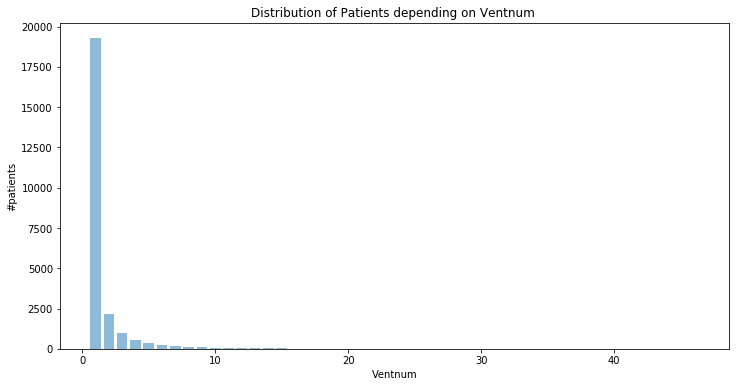

In [15]:
import matplotlib.pyplot as plt
a =case_ventnum.ventnum.value_counts().sort_index()
f, ax = plt.subplots(figsize=(12,6))
plt.bar(a.index,a.values,align='center', alpha=0.5)
plt.xlabel('Ventnum')
plt.ylabel('#patients')
plt.title('Distribution of Patients depending on Ventnum ')
plt.show()
